In [17]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import sys
import copy
from tqdm.notebook import tqdm
from scipy import stats
import networkx as nx
import random
import re
from validation_functions import *

sys.path.append("../scripts/")
from node_classification_all_models import * # uncomment later
from loader_utils import *

# plt.style.use('seaborn-deep')
plt.rcParams["text.usetex"] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amssymb,amsmath}'

plt.rcParams["figure.figsize"] = 11.7, 8.3
plt.rcParams["figure.dpi"] = 75

plt.rcParams["font.size"] = 24
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Fira Sans", 'PT Sans', 'Open Sans', 'Roboto', 'DejaVu Sans', 'Liberation Sans', 'sans-serif']
# plt.rcParams["font.sans-serif"] = ['Helvetica']

plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.fancybox"] = True
plt.rcParams["legend.fontsize"] = "small"

plt.rcParams["lines.linewidth"] = 2.5
plt.rcParams["lines.markersize"] = 14
plt.rcParams["lines.markeredgewidth"] = 2

plt.rcParams["xtick.major.size"] = 8
plt.rcParams["ytick.major.size"] = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from scipy import sparse
from networkx.algorithms import bipartite

def load_dataset(dataset, graph_path, bipartite_graph_path, label_path, 
                 inf_coords_S1_path, inf_coords_S2_path):
    
    try:
        g = nx.read_edgelist(graph_path, nodetype=int)
    except Exception:
        g = nx.read_edgelist(graph_path, nodetype=str)
        
    mapping = {node: i for i, node in enumerate(g.nodes())}
    inveresed_mapping = {i: node for i, node in enumerate(g.nodes())}
    g_relabeled = nx.relabel_nodes(g, mapping)

    if dataset == 'film':
        df_labels = pd.read_csv(label_path, sep="\t")
        df_labels.columns = ['index', 'features', 'class']
    elif dataset == 'imdb' or dataset == 'dblp': 
        df_labels = np.loadtxt(label_path)
        df_labels = np.argmax(df_labels, axis=1)
        df_labels = pd.DataFrame(df_labels)
        df_labels.reset_index(inplace=True)
        df_labels.columns = ['index', 'class']
    elif dataset == 'citeseer':
        df_labels = pd.read_csv(label_path, sep="\s+", header=None)
        df_labels.columns = ['index', 'class']
    elif dataset in ['wisconsin', 'texas', 'cornell']:
        df_labels = pd.read_csv(label_path, sep="\s+")
        df_labels.columns = ['index', 'class']
    else:
        df_labels = pd.read_csv(label_path, sep="\t", header=None)
        df_labels.columns = ['index', 'class']

    df_S1, df_nodes_S1, df_features_S1 = read_all_coordinates(1, inf_coords_S1_path, df_labels)
    df_S2, df_nodes_S2, df_features_S2 = read_all_coordinates(2, inf_coords_S2_path, df_labels)
    
    df_S1['relabeled_index'] = [mapping[x] for x in df_S1['index']]
    y_val = df_S1.sort_values('relabeled_index')['class'].values

    row_order = [str(x) for x in mapping.keys()]
    g_bipartite = bipartite.read_edgelist(bipartite_graph_path)
    
    X_features = bipartite.biadjacency_matrix(g_bipartite, row_order, weight=None)
    X_features = sparse.coo_matrix(X_features)
    
    return g_relabeled, df_S1, df_nodes_S1, df_S2, df_nodes_S2, y_val, X_features

In [19]:
def run_experiments(df_S1, df_nodes_S1, df_S2, df_nodes_S2, g_relabeled, y_val, X_features, n_times=10):
    
    test_size = 0.8
    
    res_S1 = node_classification(1, df_S1, df_nodes_S1, test_size=test_size, n_times=n_times)
    res_S2 = node_classification(2, df_S2, df_nodes_S2, test_size=test_size, n_times=n_times)
    
    methods = ['UMAP', 'DeepWalk', 'Role2Vec', 'LaplacianEigenmaps', 'NetMF', 'FeatherNode', 'MUSAE']
    methods_short = ['UMAP', 'DW', 'R2V', 'LE', 'NetMF', 'FN*', 'MUSAE*']
    methods_short = {m1: m2 for m1, m2 in zip(methods, methods_short)}
    dimensions = [2, 4, 8, 16]

    results_external = {}
    for m in tqdm(methods):
        for d in tqdm(dimensions):
            results_external[(methods_short[m], d)] = node_classification_external(
                m, d, g_relabeled, y_val, node_feature_matrix=X_features, test_size=test_size, n_times=n_times)['accuracy_vals']
            
    df_results_external = pd.DataFrame(results_external).T.reset_index()
    df_results_external.columns = ['method', 'dim', *[f'i{i}' for i in range(n_times)]]

    ## Add results from S^D models
    new_row = {'method': '$\mathbb{S}^1$','dim': 1}
    new_row |= {f'i{i}': res_S1['accuracy_unipartite'][i] for i in range(n_times)}
    df_results_external.loc[len(df_results_external)] = new_row

    new_row = {'method': 'bipartite-$\mathbb{S}^1$','dim': 1}
    new_row |= {f'i{i}': res_S1['accuracy_bipartite'][i] for i in range(n_times)}
    df_results_external.loc[len(df_results_external)] = new_row

    new_row = {'method': '$\mathbb{S}^2$','dim': 2}
    new_row |= {f'i{i}': res_S2['accuracy_unipartite'][i] for i in range(n_times)}
    df_results_external.loc[len(df_results_external)] = new_row

    new_row = {'method': 'bipartite-$\mathbb{S}^2$','dim': 2}
    new_row |= {f'i{i}': res_S2['accuracy_bipartite'][i] for i in range(n_times)}
    df_results_external.loc[len(df_results_external)] = new_row


    df_melted = df_results_external.melt(id_vars=['method', 'dim'], value_vars=[f'i{i}' for i in range(n_times)], 
                        var_name='iteration', value_name='value')
    df_melted['method_dim'] = df_melted['method'] + ' (' + df_melted['dim'].astype(str) + ')'
    median_values = df_melted.groupby('method_dim')['value'].median().sort_values(ascending=False)
    df_melted['method_dim'] = pd.Categorical(df_melted['method_dim'], categories=median_values.index, ordered=True)
    
    return df_results_external, df_melted

In [20]:
def nc_pipeline(dataset, graph_path, bipartite_graph_path, label_path, inf_coords_S1_path, inf_coords_S2_path):
    g_relabeled, df_S1, df_nodes_S1, df_S2, df_nodes_S2, y_val, X_features = load_dataset(dataset, 
                                                                                          graph_path, 
                                                                                          bipartite_graph_path, 
                                                                                          label_path, 
                                                                                          inf_coords_S1_path, 
                                                                                          inf_coords_S2_path)
    df_results_external, df_melted = run_experiments(df_S1, df_nodes_S1, 
                                                     df_S2, df_nodes_S2, 
                                                     g_relabeled, y_val, X_features)
    return df_results_external, df_melted

In [21]:
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

col_network_based = '#FFC325'#'#f6c200'
col_feature_based = '#E31B23'#'#a00e00'
col_feature_network_based = '#4063a3'#'#0086a8'

methods_category = {'UMAP': col_feature_based, 
                    'DW': col_network_based, 
                    'R2V': col_network_based, 
                    'LE': col_network_based, 
                    'NetMF': col_network_based, 
                    'FN*': col_feature_network_based, 
                    'MUSAE*': col_feature_network_based,
                    '$\mathbb{S}^1$': col_network_based,
                    'bipartite-$\mathbb{S}^1$': col_feature_based,
                    '$\mathbb{S}^2$': col_network_based,
                    'bipartite-$\mathbb{S}^2$': col_feature_based}


def plot_boxplot(df_melted, title, ylabel='Accuracy'):
    fig, ax = plt.subplots(figsize=(16, 8))

    boxprops = dict(color="black")
    whiskerprops = dict(color="black")
    capprops = dict(color="black")
    medianprops = dict(color="black")
    
    boxplot_sorted_yaxis = df_melted.boxplot(column='value', by='method_dim', grid=False, rot=90, ax=ax,
                                             boxprops=boxprops, whiskerprops=whiskerprops, 
                                             capprops=capprops, medianprops=medianprops)

    xticks = ax.get_xticks()
    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

    for i, label in enumerate(xticklabels):
        method_name = label.split()[0]
        if method_name in methods_category:
            color = methods_category[method_name]
            ax.axvspan(xticks[i] - 0.5, xticks[i] + 0.5, color=color, alpha=0.2, linewidth=0)

            if 'mathbb' in method_name: 
                #ax.axvline(xticks[i] - 0.5, color='black', alpha=0.5, linewidth=1)
                #ax.axvline(xticks[i] + 0.5, color='black', alpha=0.5, linewidth=1)
                
                rect = mpatches.Rectangle(
                    (xticks[i] - 0.5, ax.get_ylim()[0]),  # Bottom-left corner
                    width=1,                             # Width of the span
                    height=ax.get_ylim()[1] - ax.get_ylim()[0],  # Height of the span
                    fill=False,
                    alpha=0.1,
                    edgecolor=None,
                    hatch='//'
                )
                ax.add_patch(rect)

    legend_elements = [Patch(facecolor=col_network_based, edgecolor=col_network_based, label='Network-based', alpha=0.3),
                       Patch(facecolor=col_feature_based, edgecolor=col_feature_based, label='Feature-based', alpha=0.3),
                       Patch(facecolor=col_feature_network_based, edgecolor=col_feature_network_based, label='Feature+Network-based', alpha=0.3)]
    
    ax.legend(handles=legend_elements, loc='upper right', framealpha=1, fontsize=22)
    plt.title(title, fontsize=32)
    plt.suptitle('')
    plt.ylabel(ylabel)
    plt.xlabel('')
    plt.tight_layout()


In [6]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/film"

# res_film_full, res_film = nc_pipeline('film', f"{p}/out1_graph_edges.edge", f"{p}/film_bipartite.edge", 
#                                       f"{p}/out1_node_feature_label.txt", f"{p}/eS1/", f"{p}/eS2/")

In [7]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/imdb"

# res_imdb_full, res_imdb = nc_pipeline('imdb', f"{p}/eS1/imdb_mam_GC.edge", f"{p}/imdb_mam_bipartite.edge", 
#                                       f"{p}/imdb_label.txt", f"{p}/eS1/", f"{p}/eS2/")

In [8]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/cora/"

# res_cora_full, res_cora = nc_pipeline('cora', f"{p}/cora_GC.edge", f"{p}/cora_bipartite.edge", 
#                                       f"{p}/cora.labels", f"{p}/eS1/", f"{p}/eS2/")

In [9]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/dblp/"

# res_dblp_full, res_dblp = nc_pipeline('dblp', f"{p}/eS1/dblp_pprefp_GC.edge", f"{p}/dblp_pprefp_bipartite.edge", 
#                                       f"{p}/dblp_label.txt", f"{p}/eS1/", f"{p}/eS2/")

In [10]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/citeseer/"

# res_citeseer_full, res_citeseer = nc_pipeline('citeseer', f"{p}/citeseer_GC_fixed.edge", 
#                                               f"{p}/citeseer_GC_fixed_bipartite.edge", 
#                                               f"{p}/citeseer.labels", f"{p}/eS1/", f"{p}/eS2/")

In [28]:
p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/wisconsin/"

res_wisconsin_full, res_wisconsin = nc_pipeline('wisconsin', f"{p}/out1_graph_edges.edge", 
                                                f"{p}/out1_graph_edges_bipartite.edge", 
                                                f"{p}/wisconsin.labels", f"{p}/eS1/", f"{p}/eS2/")

  0%|          | 0/4 [00:00<?, ?it/s]/home/rob/repo/f-mercator-all/f-mercator/tmp_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

 25%|██▌       | 1/4 [00:01<00:04,  1.51s/it]/home/rob/repo/f-mercator-all/f-mercator/tmp_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

 50%|█████     | 2/4 [00:02<00:02,  1.43s/it]/home/rob/repo/f-mercator-all/f-mercator/tmp_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(

 75%|███████▌  | 3/4 [00:04<00:01,  1.40s/it]/home/rob/repo/f-mercator-all/f-mercator/tmp_venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarn

In [12]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/texas/"

# res_texas_full, res_texas = nc_pipeline('texas', f"{p}/out1_graph_edges.edge", 
#                                         f"{p}/out1_graph_edges_bipartite.edge", 
#                                         f"{p}/texas.labels", f"{p}/eS1/", f"{p}/eS2/")

In [13]:
# p = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/webkb/cornell/"

# res_cornell_full, res_cornell = nc_pipeline('cornell', f"{p}/out1_graph_edges.edge", 
#                                             f"{p}/out1_graph_edges_bipartite.edge", 
#                                             f"{p}/cornell.labels", f"{p}/eS1/", f"{p}/eS2/")

In [14]:
# data = {
#     'res_film': res_film,
#     'res_imdb': res_imdb,
#     'res_cora': res_cora,
#     'res_dblp': res_dblp,
#     'res_citeseer': res_citeseer,
#     'res_wisconsin': res_wisconsin,
#     'res_texas': res_texas,
#     'res_cornell': res_cornell,
# }

In [8]:
import pickle
# with open('/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/nc_comparison_all_models_10_01_25.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [9]:
with open('/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/new-f-mercator-datasets/nc_comparison_all_models.pickle', 'rb') as f:
    data = pickle.load(f)

In [10]:
res_film = data['res_film']
res_imdb = data['res_imdb']
res_cora = data['res_cora']
res_dblp = data['res_dblp']
res_citeseer = data['res_citeseer']
res_wisconsin = data['res_wisconsin']
res_texas = data['res_texas']
res_cornell = data['res_cornell']

---
---

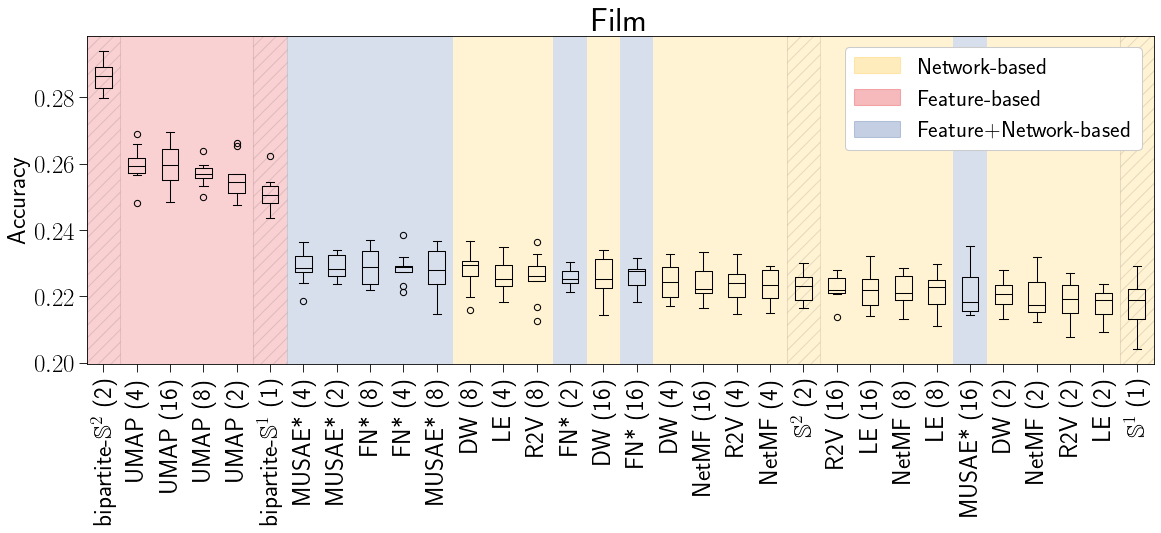

In [11]:
plot_boxplot(res_film, 'Film')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_film.pdf")

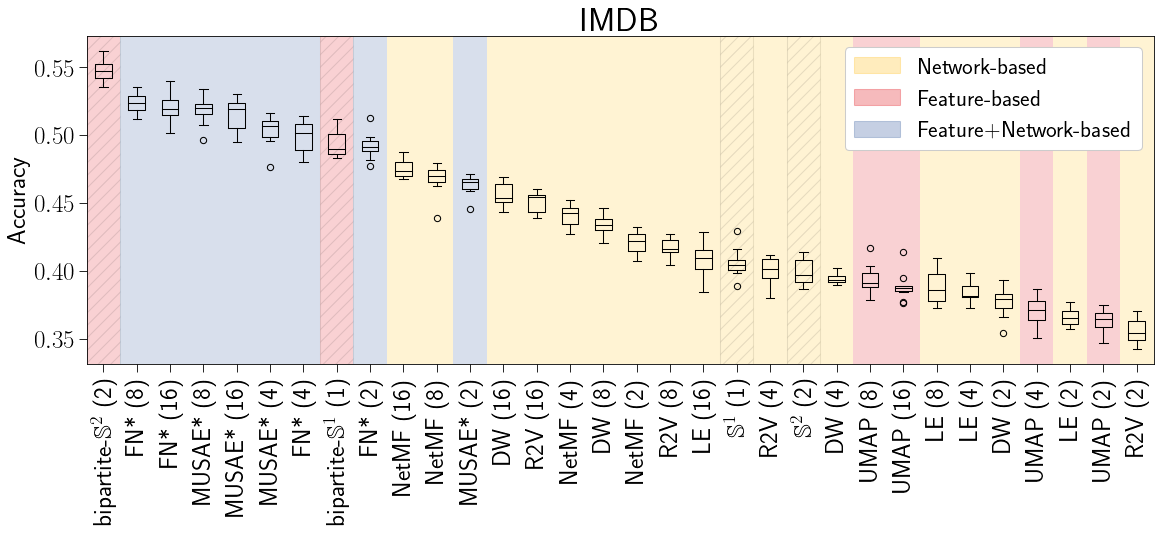

In [20]:
plot_boxplot(res_imdb, 'IMDB')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_imdb.pdf")

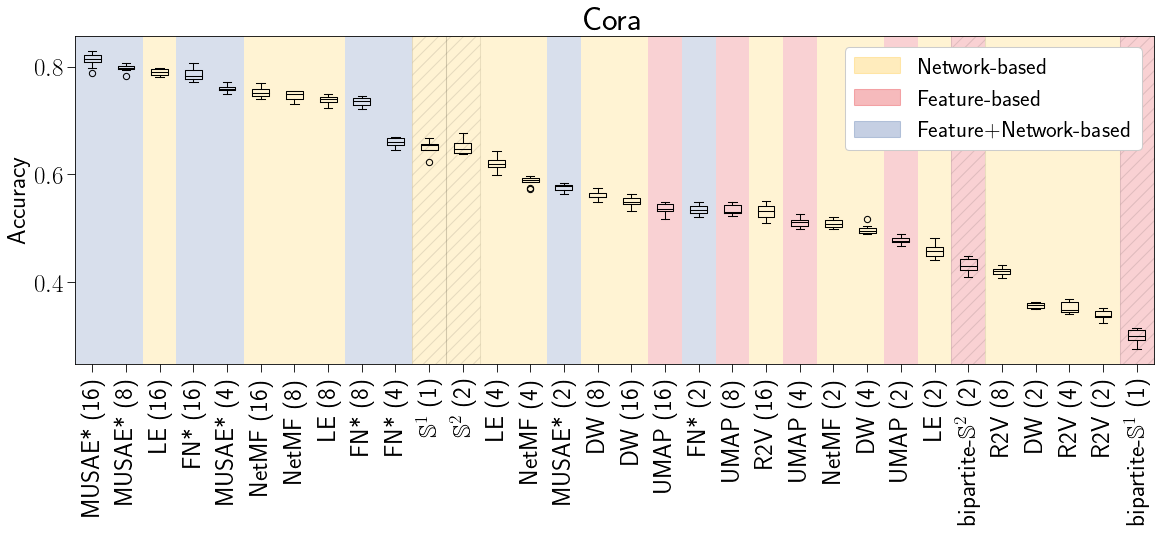

In [21]:
plot_boxplot(res_cora, 'Cora')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_cora.pdf")

In [38]:
# plot_boxplot(res_dblp, 'DBLP')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_dblp.pdf")

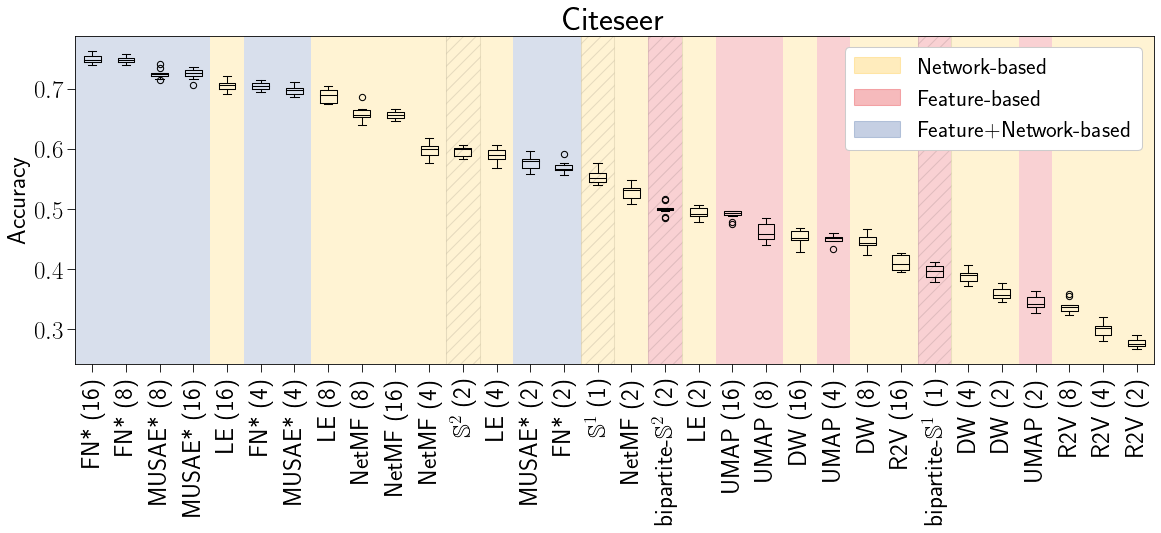

In [23]:
plot_boxplot(res_citeseer, 'Citeseer')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_citeseer.pdf")

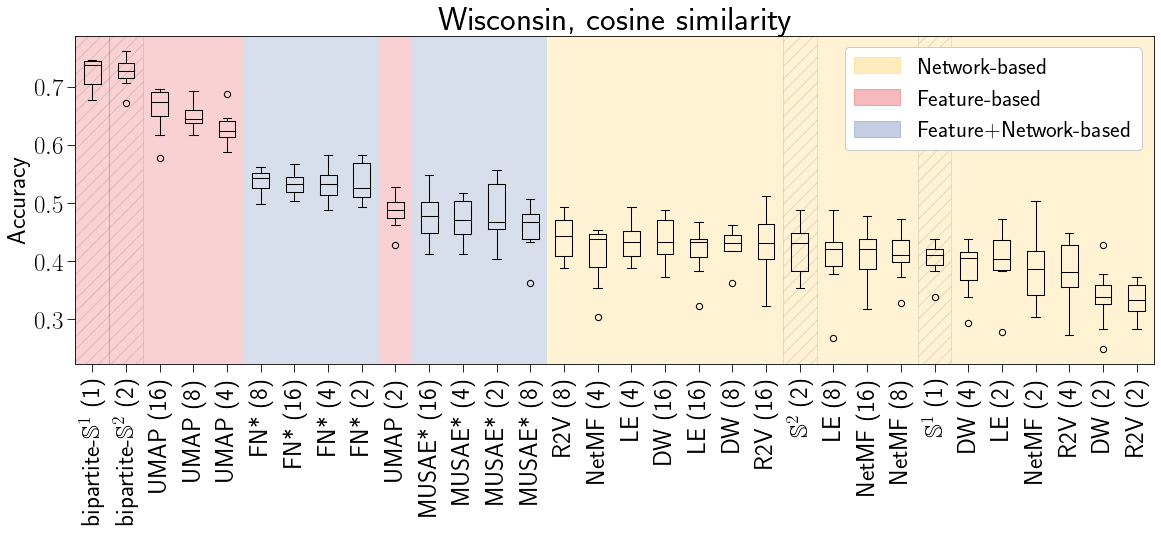

In [30]:
plot_boxplot(res_wisconsin, 'Wisconsin, cosine similarity') 

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/Rebuttal/plots/nc_wisconsin_80_20_split.pdf")
# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/ReSubmissionCommPhys/Rebuttal/plots/nc_wisconsin_cosine_similarity.pdf")

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_wisconsin.pdf")

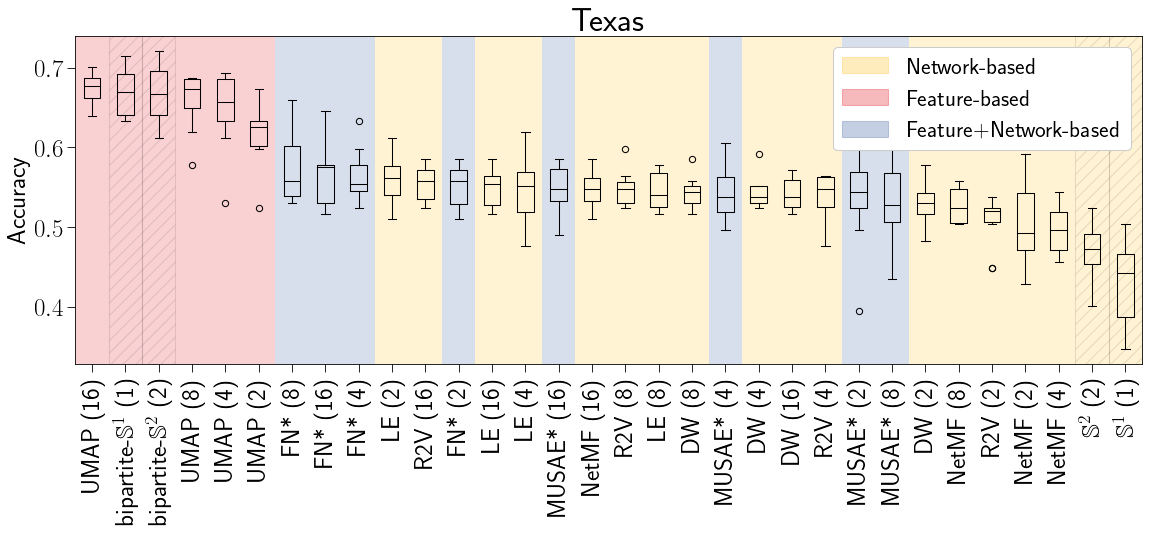

In [25]:
plot_boxplot(res_texas, 'Texas')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_texas.pdf")

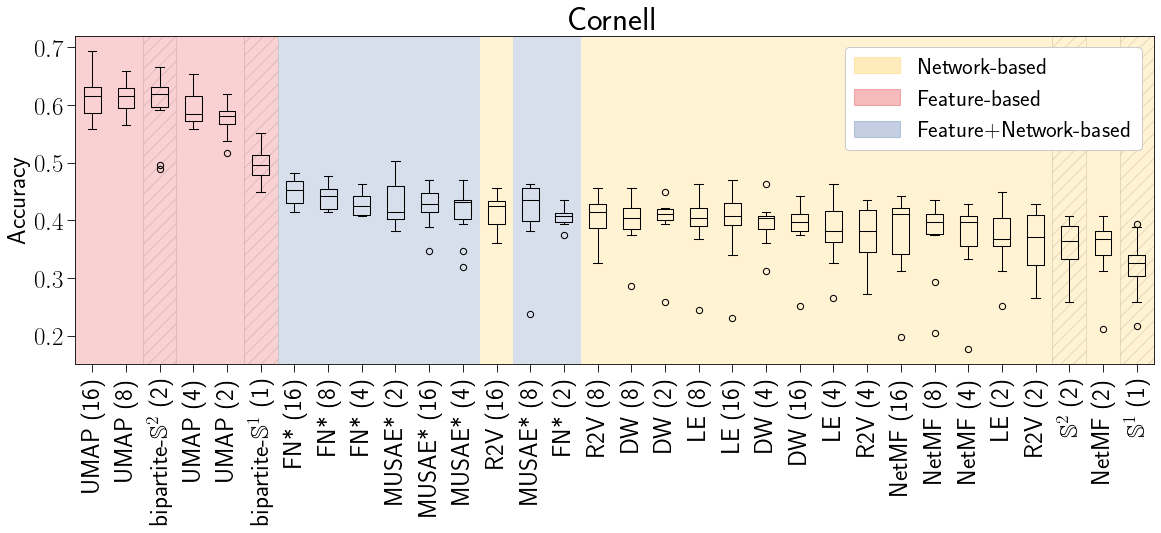

In [26]:
plot_boxplot(res_cornell, 'Cornell')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_cornell.pdf")

In [12]:
# Create a ranking per dataset 
def get_ranking(res):
    df_ranking = res.groupby(['method_dim'])\
        .agg({'value': 'mean', 'method': lambda x: x.iloc[0], 'dim': lambda x: x.iloc[0]})\
        .reset_index()\
        .sort_values('value', ascending=False)\
        .reset_index()[['index', 'method_dim', 'method', 'dim']]
    df_ranking['rank'] = df_ranking['index'] + 1
    return df_ranking[['rank', 'method_dim', 'method', 'dim']]

In [13]:
rank_film = get_ranking(res_film)
rank_imdb = get_ranking(res_imdb)
rank_dblp = get_ranking(res_dblp)
rank_cora = get_ranking(res_cora)
rank_citeseer = get_ranking(res_citeseer)
rank_wisconsin = get_ranking(res_wisconsin)
rank_texas = get_ranking(res_texas)
rank_cornell = get_ranking(res_cornell)

/tmp/ipykernel_1100921/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_1100921/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_1100921/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_1100921/1836551368.py:3: 

In [14]:
def plot_rank_boxplot(df_list_rank, title):
    fig, ax = plt.subplots(figsize=(16, 8))

    boxprops = dict(color="black")
    whiskerprops = dict(color="black")
    capprops = dict(color="black")
    medianprops = dict(color="black")
    
    df_all = pd.concat(df_list_rank, ignore_index=True)
    median_value = df_all.groupby('method_dim')['rank'].median().sort_values(ascending=True)
    df_all['method_dim'] = pd.Categorical(df_all['method_dim'], categories=median_value.index, ordered=True)
    
    boxplot_sorted_yaxis = df_all.boxplot(column='rank', by='method_dim', grid=False, rot=90, ax=ax,
                                         boxprops=boxprops, whiskerprops=whiskerprops, 
                                         capprops=capprops, medianprops=medianprops)

    xticks = ax.get_xticks()
    xticklabels = [tick.get_text() for tick in ax.get_xticklabels()]

    for i, label in enumerate(xticklabels):
        method_name = label.split()[0]
        if method_name in methods_category:
            color = methods_category[method_name]
            ax.axvspan(xticks[i] - 0.5, xticks[i] + 0.5, color=color, alpha=0.2, linewidth=0)

            if 'mathbb' in method_name: 
                #ax.axvline(xticks[i] - 0.5, color='black', alpha=0.5, linewidth=1)
                #ax.axvline(xticks[i] + 0.5, color='black', alpha=0.5, linewidth=1)
                
                rect = mpatches.Rectangle(
                    (xticks[i] - 0.5, ax.get_ylim()[0]),  # Bottom-left corner
                    width=1,                             # Width of the span
                    height=ax.get_ylim()[1] - ax.get_ylim()[0],  # Height of the span
                    fill=False,
                    alpha=0.1,
                    edgecolor=None,
                    hatch='//'
                )
                ax.add_patch(rect)

    legend_elements = [Patch(facecolor=col_network_based, edgecolor=col_network_based, label='Network-based', alpha=0.3),
                       Patch(facecolor=col_feature_based, edgecolor=col_feature_based, label='Feature-based', alpha=0.3),
                       Patch(facecolor=col_feature_network_based, edgecolor=col_feature_network_based, label='Feature+Network-based', alpha=0.3)]
    
    ax.legend(handles=legend_elements, loc='lower right', framealpha=1, fontsize=22)
    plt.title(title, fontsize=32)
    plt.suptitle('')
    plt.ylabel('Rank')
    plt.xlabel('')
    plt.tight_layout()

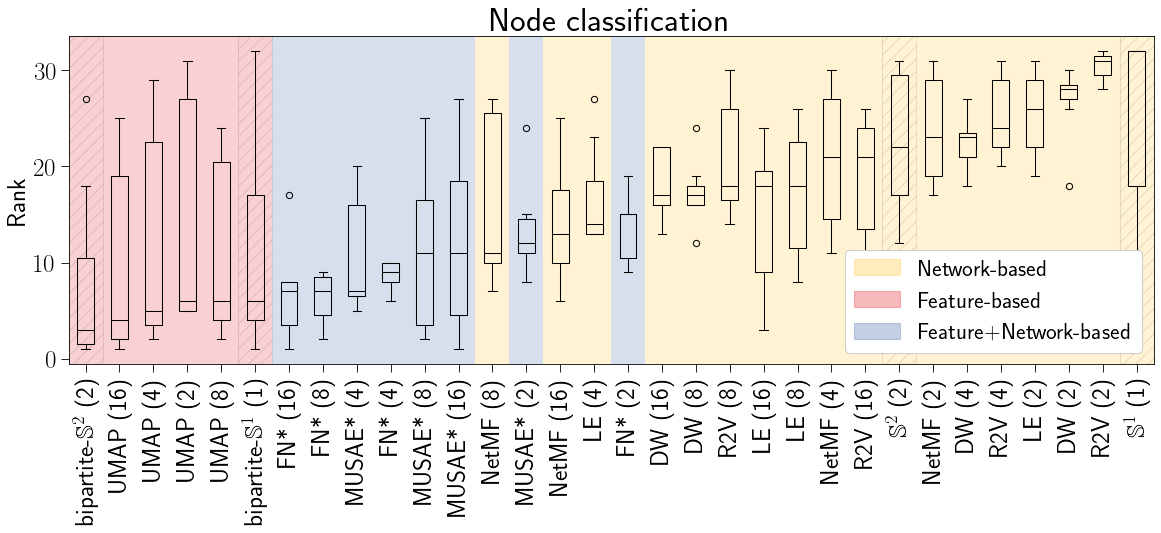

In [15]:
plot_rank_boxplot([rank_film, rank_imdb, rank_cora, rank_citeseer,
                   rank_texas, rank_wisconsin, rank_cornell], 'Node classification')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/nc_rank.pdf")

---
---
### Link prediction

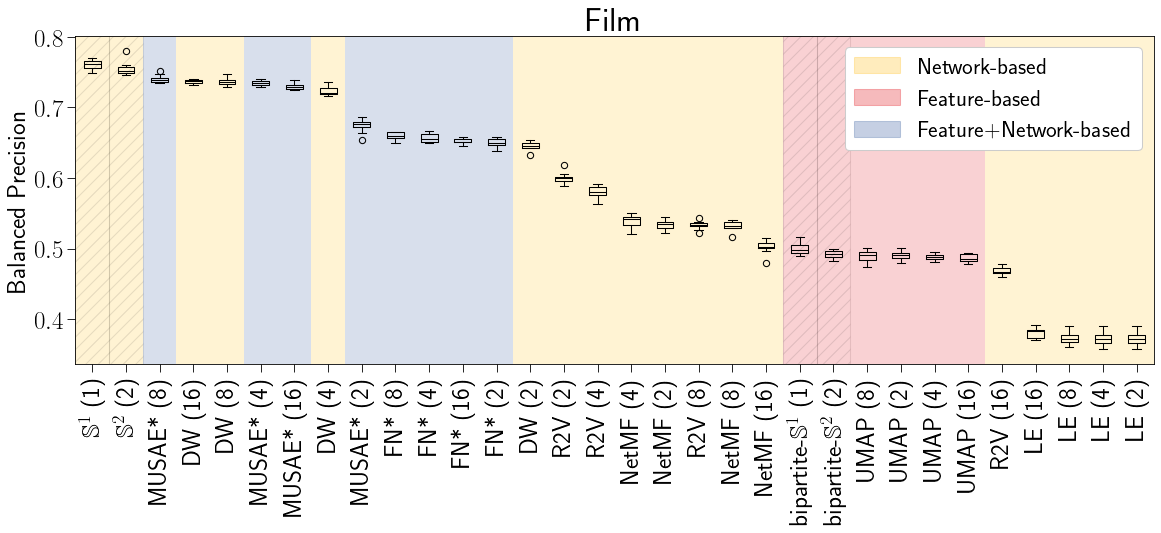

In [16]:
lp_res_film = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/film_prc_10.csv")
mean_values = lp_res_film.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_film['method_dim'] = pd.Categorical(lp_res_film['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_film, 'Film', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_film.pdf")

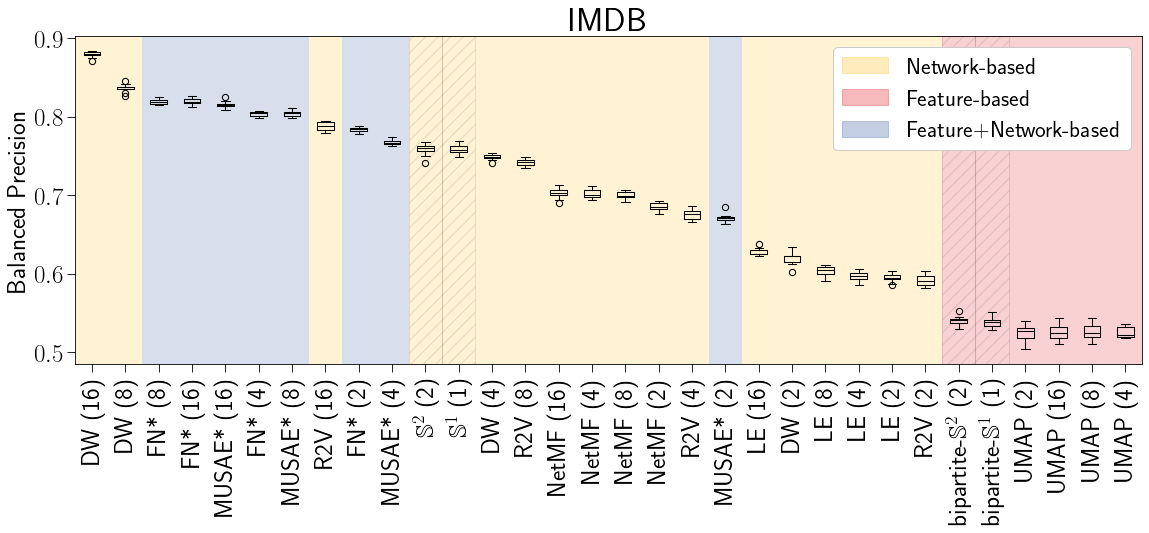

In [17]:
lp_res_imdb = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/imdb_mam_prc_10.csv")
mean_values = lp_res_imdb.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_imdb['method_dim'] = pd.Categorical(lp_res_imdb['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_imdb, 'IMDB', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_imdb.pdf")

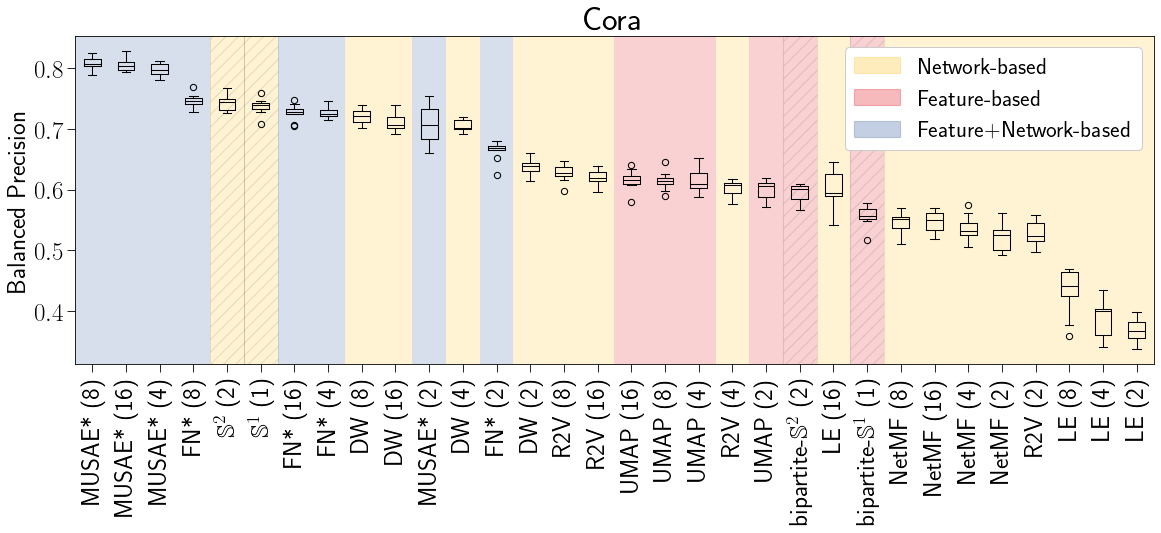

In [18]:
lp_res_cora = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Cora_prc_10.csv")
mean_values = lp_res_cora.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_cora['method_dim'] = pd.Categorical(lp_res_cora['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_cora, 'Cora', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_cora.pdf")

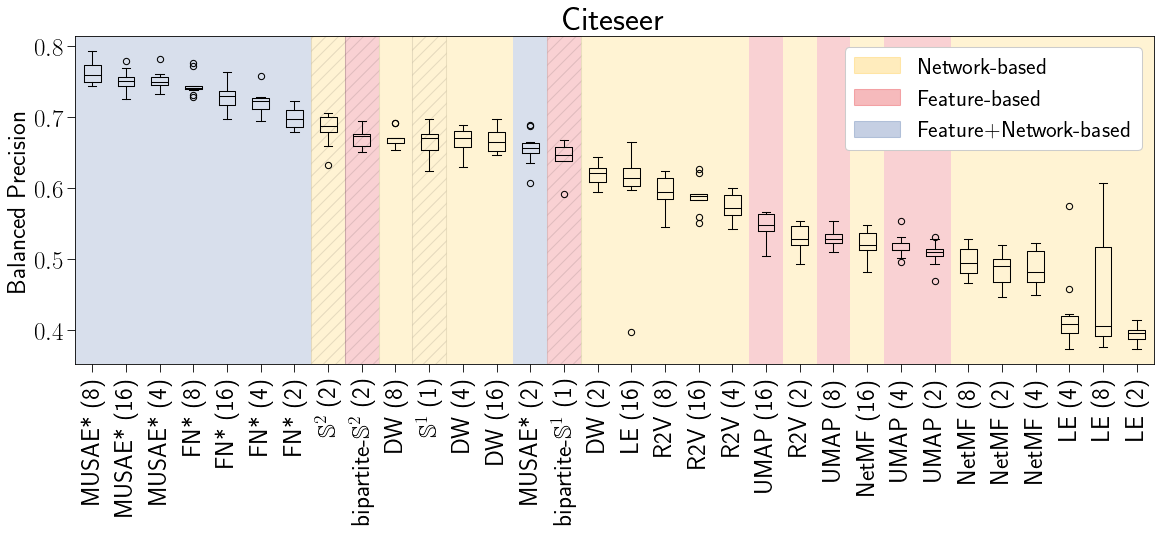

In [19]:
lp_res_citeseer = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Citeseer_prc_10.csv")
mean_values = lp_res_citeseer.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_citeseer['method_dim'] = pd.Categorical(lp_res_citeseer['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_citeseer, 'Citeseer', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_citeseer.pdf")


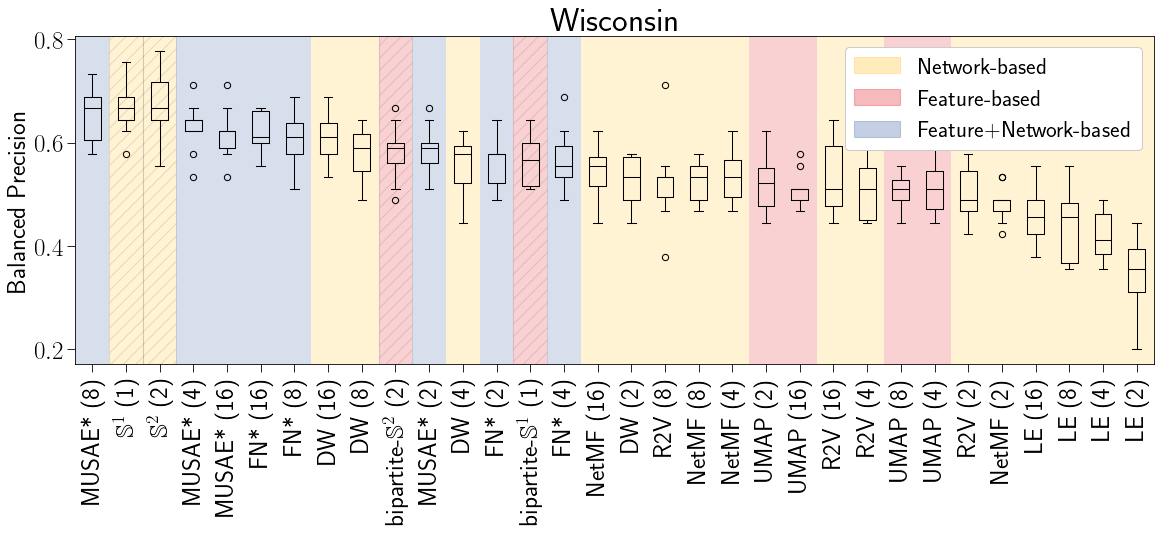

In [20]:
lp_res_wisconsin = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Wisconsin_prc_10.csv")
mean_values = lp_res_wisconsin.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_wisconsin['method_dim'] = pd.Categorical(lp_res_wisconsin['method_dim'], 
                                                categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_wisconsin, 'Wisconsin', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_wisconsin.pdf")

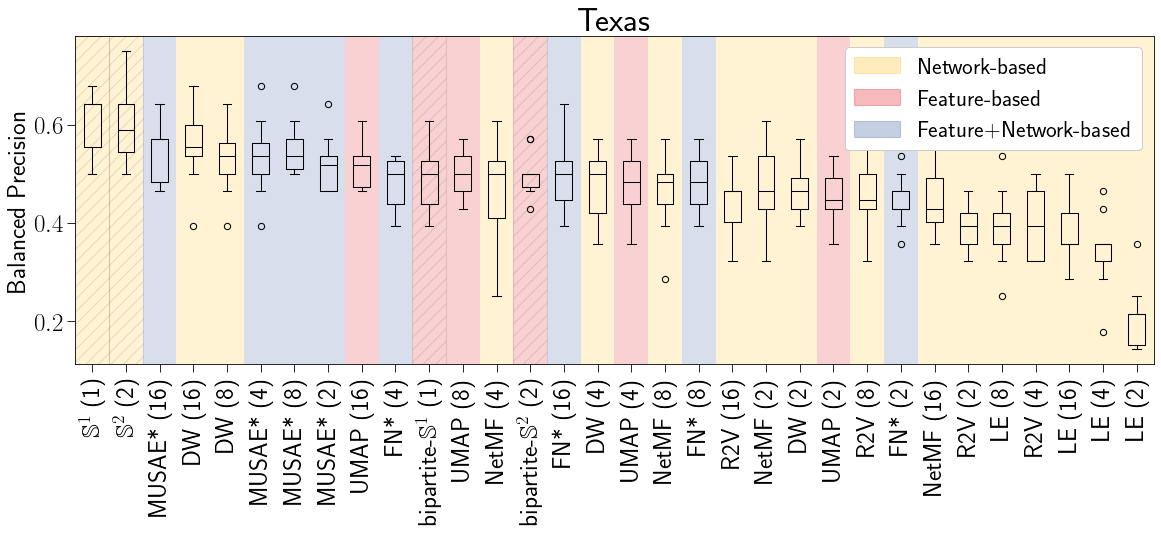

In [21]:
lp_res_texas = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Texas_prc_10.csv")
mean_values = lp_res_texas.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_texas['method_dim'] = pd.Categorical(lp_res_texas['method_dim'], 
                                            categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_texas, 'Texas', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_texas.pdf")

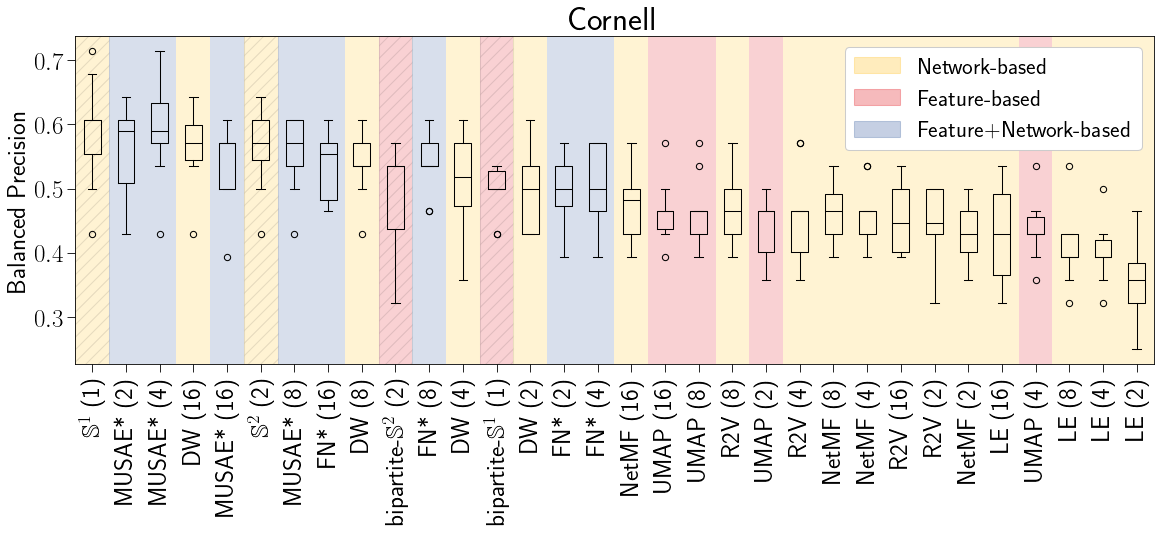

In [22]:
lp_res_cornell = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Cornell_prc_10.csv")
mean_values = lp_res_cornell.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_cornell['method_dim'] = pd.Categorical(lp_res_cornell['method_dim'], 
                                            categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_cornell, 'Cornell', 'Balanced Precision')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_cornell.pdf")

In [23]:
lp_rank_film = get_ranking(lp_res_film)
lp_rank_imdb = get_ranking(lp_res_imdb)
lp_rank_cora = get_ranking(lp_res_cora)
lp_rank_citeseer = get_ranking(lp_res_citeseer)
lp_rank_wisconsin = get_ranking(lp_res_wisconsin)
lp_rank_texas = get_ranking(lp_res_texas)
lp_rank_cornell = get_ranking(lp_res_cornell)

/tmp/ipykernel_1100921/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_1100921/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_1100921/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_1100921/1836551368.py:3: 

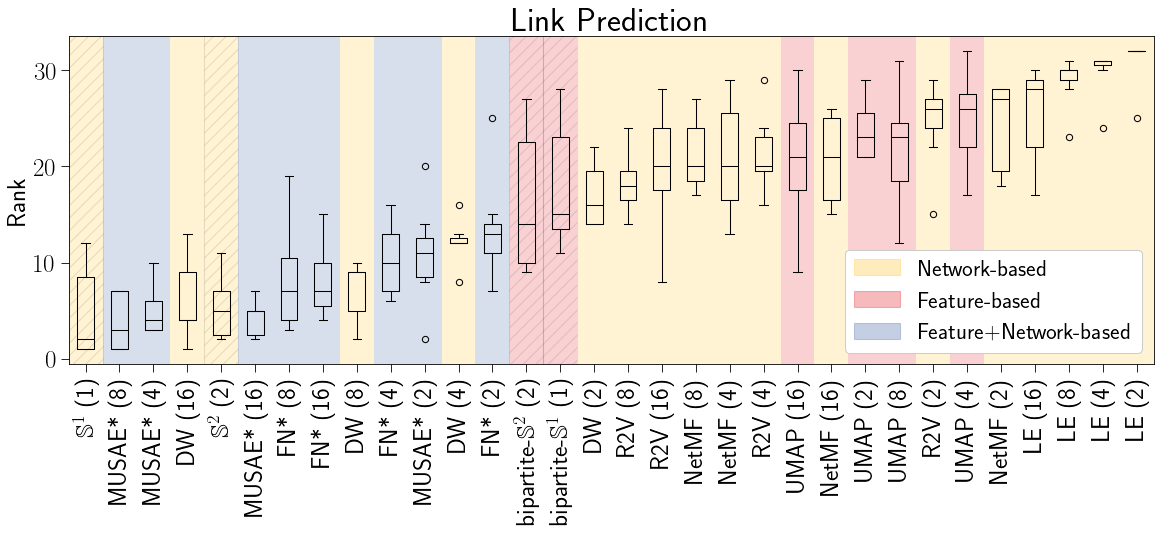

In [24]:
plot_rank_boxplot([lp_rank_film, lp_rank_imdb, lp_rank_cora, lp_rank_citeseer,
                   lp_rank_wisconsin, lp_rank_texas, lp_rank_cornell], 'Link Prediction')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_precision_rank.pdf")

In [36]:
methods = ['bipartite-$\\mathbb{S}^1$', 'bipartite-$\\mathbb{S}^2$',
           '$\\mathbb{S}^1$', '$\\mathbb{S}^2$',
           'UMAP', 'DeepWalk', 'Role2Vec', 'LaplacianEigenmaps', 'NetMF', 'FeatherNode', 'MUSAE']
methods_short = ['bipartite-$\\mathbb{S}^1$', 'bipartite-$\\mathbb{S}^2$',
           '$\\mathbb{S}^1$', '$\\mathbb{S}^2$', 'UMAP', 'DW', 'R2V', 'LE', 'NetMF', 'FN*', 'MUSAE*']

methods_long = {m1: m2 for m1, m2 in zip(methods_short, methods)}

colors = [
  "#1C5A62", "#3C6D56",
  "#687B3E", "#9D892B", "#D29343",
  "#F8A17B", "#FDB7BC", "#FACCFA"][::2]

colors =[
  "#e76254",
  "#ef8a47",
  "#f7aa58",
  "#ffd06f",
  "#ffe6b7",
  "#aadce0",
  "#72bcd5",
  "#528fad",
  "#376795",
  "#1e466e"
]
def plot_rank_comparison(dfs):
    plt.figure(figsize=(10, 6))
    
    symbols = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', 'P', 'H', 'd', '<', '>', '8']
    method_symbols = dict(zip(methods_short, symbols))
    
    for i, df in enumerate(dfs):
        for method in methods_short:
            subset = df[df['method_x'] == method]
            plt.scatter(
                subset['rank_x'], subset['rank_y'], 
                s=1/subset['dim_x'] * 500, # Lower dimension, larger point 
                #label=methods_long[method], 
                alpha=0.9,
                edgecolor='black',
                marker=method_symbols[method],
                color=colors[i],
            )

    plt.xlabel('NC rank')
    plt.ylabel('LP rank')
    legend_handles = [
        plt.Line2D([0], [0], marker=symbol, color='white', markerfacecolor='white', 
                   markeredgecolor='black', markersize=15, label=methods_long[method])
        for method, symbol in method_symbols.items()
    ]
    plt.legend(handles=legend_handles, bbox_to_anchor=(1.03, 1.02), loc='upper left')
    plt.tight_layout()

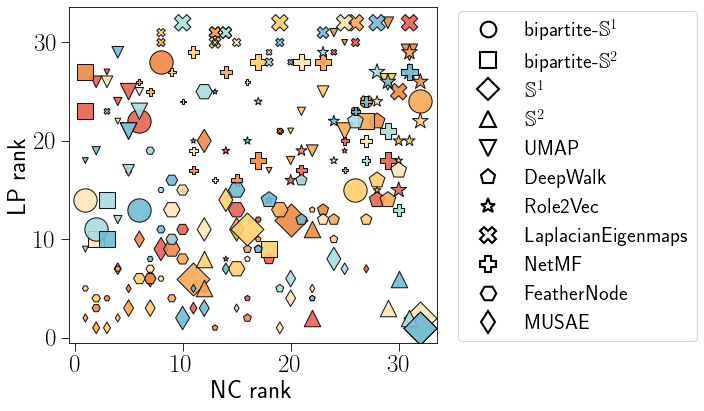

In [37]:
combined_rank_film = rank_film.merge(lp_rank_film, on='method_dim')
combined_rank_imdb = rank_imdb.merge(lp_rank_imdb, on='method_dim')
combined_rank_cora = rank_cora.merge(lp_rank_cora, on='method_dim')
combined_rank_citeseer = rank_citeseer.merge(lp_rank_citeseer, on='method_dim')
combined_rank_wisconsin = rank_wisconsin.merge(lp_rank_wisconsin, on='method_dim')
combined_rank_texas = rank_texas.merge(lp_rank_texas, on='method_dim')
combined_rank_cornell = rank_cornell.merge(lp_rank_cornell, on='method_dim')

plot_rank_comparison([combined_rank_film, combined_rank_imdb, combined_rank_cora,
                      combined_rank_citeseer, combined_rank_wisconsin, combined_rank_texas,
                      combined_rank_cornell])

In [38]:
method_colors = {
    'bipartite-$\\mathbb{S}^1$': '#D55E00',  # Vermilion
    'bipartite-$\\mathbb{S}^2$': '#E69F00',  # Orange
    '$\\mathbb{S}^1$': '#F0E442',            # Yellow
    '$\\mathbb{S}^2$': '#009E73',            # Bluish Green
    'UMAP': '#56B4E9',                       # Sky Blue
    'DW': '#0072B2',                         # Blue
    'R2V': '#CC79A7',                        # Reddish Purple
    'LE': '#999999',                         # Gray
    'NetMF': '#A6761D',                      # Brown
    'FN*': '#8DB600',                        # Bluish Green (reused for balance)
    'MUSAE*': '#D73027'                      # Strong Red
}

# Define markers for each dataset; you can define as many as you have datasets
markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', 'P', 'H', 'd', '<', '>', '8']


from matplotlib.patches import Patch, Rectangle, FancyBboxPatch

def plot_rank_comparison_with_legends(dfs, dataset_names=None):
    """
    dfs: list of DataFrames (each representing a dataset)
    dataset_names: optional list of dataset names for the legend
    """
    # Create a two-subfigure layout
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))#, gridspec_kw={'width_ratios': [2, 1]})
    
    ax_plot, ax_legend = axs
    ax_legend.axis("off")  # Hide the second subplot axis (used for legends only)

    # If user doesn't pass dataset_names, just label them 1..N
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(dfs))]
    
    # 1) Plot all points in the first subplot
    for i, df in enumerate(dfs):
        marker_for_this_dataset = markers[i]
        for method in methods_short:
            subset = df[df['method_x'] == method]
            ax_plot.scatter(
                subset['rank_x'], subset['rank_y'], 
                s=1/subset['dim_x'] * 500,    # Lower dimension => bigger point
                alpha=0.9,
                edgecolor='black',
                marker=marker_for_this_dataset,  # Marker depends on dataset
                color=method_colors[method],     # Color depends on method
            )

    ax_plot.set_xlabel('NC rank')
    ax_plot.set_ylabel('LP rank')
    
    # 2) Create a legend for the methods (colors) using patches
    method_legend_handles = []
#     for method in methods_short:
#         # Use a shorter rectangle by customizing the width and height
#         handle = FancyBboxPatch(
#             (0, 0),  # Not relevant for legend placement
#             width=1,  # Fixed width (ignored by legend scaling)
#             height=1,  # Shorter height
#             boxstyle="round,pad=0.3",  # Rounded corners for aesthetics
#             edgecolor='black',
#             facecolor=method_colors[method],
#             label=methods_long[method]
#         )
#         method_legend_handles.append(handle)

    for method in methods_short:
        handle = Patch(
            edgecolor='black', 
            facecolor=method_colors[method], 
            label=methods_long[method]
        )
        method_legend_handles.append(handle)
        
    method_legend = ax_legend.legend(
        handles=method_legend_handles, 
        loc=(-0.05, 0), handletextpad=0.7, labelspacing=0.5,#fancybox = True,
    )
    ax_legend.add_artist(method_legend)  # Add the methods legend

    # 3) Create a legend for the datasets (markers)
    dataset_legend_handles = []
    for i, name in enumerate(dataset_names):
        handle = plt.Line2D(
            [0], [0],
            marker=markers[i], 
            linestyle='None',
            markeredgecolor='black',
            markerfacecolor='white',
            markersize=13,
            label=name
        )
        dataset_legend_handles.append(handle)

    dataset_legend = ax_legend.legend(
        handles=dataset_legend_handles, 
        loc=(0.6, 0), handletextpad=0.7, labelspacing=0.3,
    )
    ax_legend.add_artist(dataset_legend)  # Add the datasets legend

    plt.tight_layout()


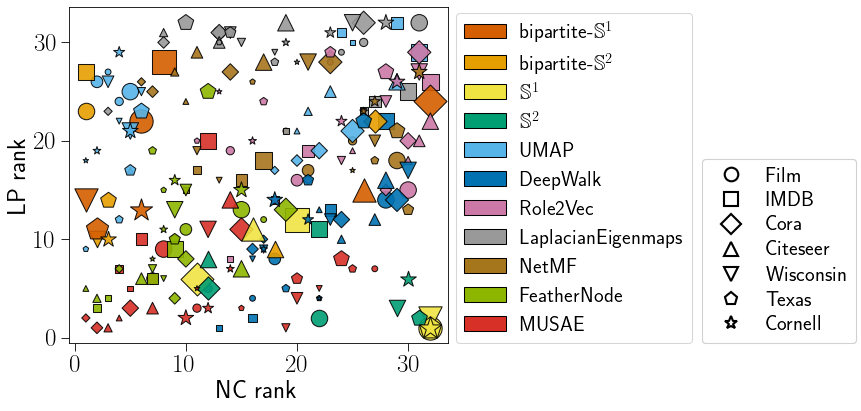

In [39]:
plot_rank_comparison_with_legends([combined_rank_film, combined_rank_imdb, combined_rank_cora,
                                   combined_rank_citeseer, combined_rank_wisconsin, combined_rank_texas,
                                   combined_rank_cornell], 
                                 ['Film', 'IMDB', 'Cora', 'Citeseer', 'Wisconsin', 'Texas', 'Cornell'])

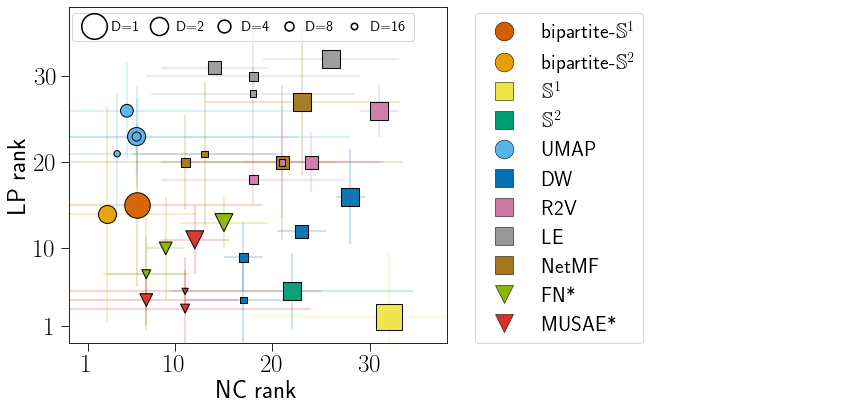

In [40]:
from matplotlib.lines import Line2D

method_colors = {
    'bipartite-$\\mathbb{S}^1$': '#D55E00',  # Vermilion
    'bipartite-$\\mathbb{S}^2$': '#E69F00',  # Orange
    '$\\mathbb{S}^1$': '#F0E442',            # Yellow
    '$\\mathbb{S}^2$': '#009E73',            # Bluish Green
    'UMAP': '#56B4E9',                       # Sky Blue
    'DW': '#0072B2',                         # Blue
    'R2V': '#CC79A7',                        # Reddish Purple
    'LE': '#999999',                         # Gray
    'NetMF': '#A6761D',                      # Brown
    'FN*': '#8DB600',                        # Bluish Green (reused for balance)
    'MUSAE*': '#D73027'                      # Strong Red
}

method_markers = {
    'bipartite-$\\mathbb{S}^1$': 'o',  
    'bipartite-$\\mathbb{S}^2$': 'o',  
    '$\\mathbb{S}^1$': 's',            
    '$\\mathbb{S}^2$': 's',            
    'UMAP': 'o',                       
    'DW': 's',                         
    'R2V': 's',                       
    'LE': 's',                         
    'NetMF': 's',                      
    'FN*': 'v',                        
    'MUSAE*': 'v'                      
}


combined_df = pd.concat([combined_rank_film, combined_rank_imdb, combined_rank_cora,
                         combined_rank_citeseer, combined_rank_wisconsin, combined_rank_texas,
                         combined_rank_cornell])

grouped_with_std = combined_df.groupby("method_dim").agg(
    avg_rank_x=("rank_x", "median"),
    std_rank_x=("rank_x", lambda x: x.quantile(0.75) - x.quantile(0.25)),
    avg_rank_y=("rank_y", "median"),
    std_rank_y=("rank_y", lambda x: x.quantile(0.75) - x.quantile(0.25)),
    dim=("dim_x", "first"),
    method=("method_x", "first")
).reset_index()

grouped_with_std["point_size"] = 1 / grouped_with_std["dim"]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for method in grouped_with_std['method'].unique():
    subset = grouped_with_std[grouped_with_std['method'] == method]
    axs[0].scatter(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        s=subset["point_size"] * 600,
        alpha=0.95,
        edgecolor='black',
        color=method_colors[method],
        zorder=20,
        marker=method_markers[method]
    )
    axs[0].errorbar(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        xerr=subset["std_rank_x"],
        yerr=subset["std_rank_y"],
        fmt='none',
        ecolor=method_colors[method],  # Match error bar color to point color
        alpha=0.2,
        capsize=0,
        zorder=0,
        elinewidth=2,
    )

# axs[0].errorbar(
#     grouped_with_std["avg_rank_x"],
#     grouped_with_std["avg_rank_y"],
#     xerr=grouped_with_std["std_rank_x"],
#     yerr=grouped_with_std["std_rank_y"],
#     fmt='none',
#     ecolor='gray',
#     alpha=0.3,
#     capsize=0,
#     zorder=0,
#     elinewidth=2,
# )

axs[0].set_xlabel("NC rank")
axs[0].set_ylabel("LP rank")

dim_legend_sizes = sorted(grouped_with_std['dim'].unique())
legend_elements_sizes = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
           markersize=np.sqrt((1 / dim) * 600), mec='black', mew=1.5, 
           label=f"D={dim}")
    for dim in dim_legend_sizes
]

axs[0].legend(handles=legend_elements_sizes, loc=(0.01, 0.9), fontsize=14, labelspacing=0.8,
             borderpad=0.5, ncol=5, columnspacing=0.3, handletextpad=0.2)

axs[0].set_yticks([1, 10, 20, 30])
axs[0].set_xticks([1, 10, 20, 30])

axs[0].set_xlim(-1, 38)
axs[0].set_ylim(-1, 38)

legend_elements = [
    Line2D([0], [0], marker=method_markers[method], 
           color='w', markerfacecolor=method_colors[method], 
           markersize=18, mec='black', mew=0.5, label=method)
    for method in method_colors.keys()
]

axs[1].legend(handles=legend_elements, loc=(0,0), fontsize=20)
axs[1].axis('off')

plt.tight_layout(w_pad=0)

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/average_lp_nc_rank.pdf")

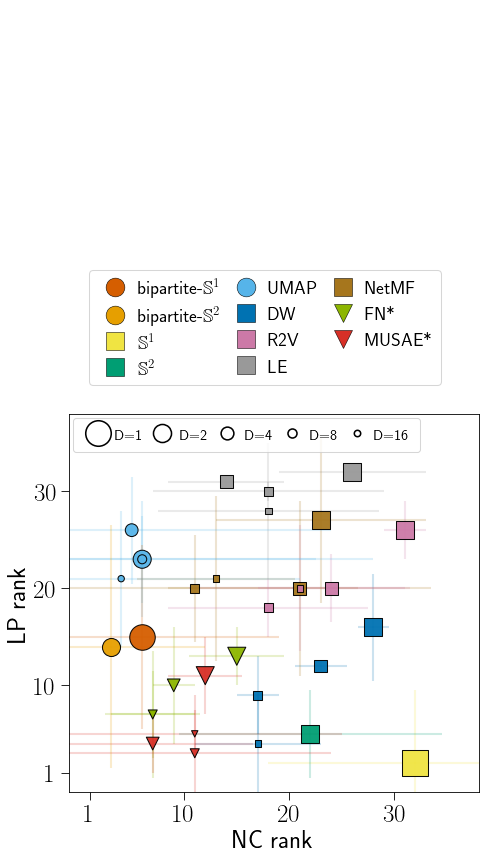

In [41]:
fig, axs = plt.subplots(2, 1, figsize=(7, 12))

# Legend (top subplot)
axs[0].axis('off')  # Turn off the axis
legend_elements = [
    Line2D([0], [0], marker=method_markers[method],
           color='w', markerfacecolor=method_colors[method],
           markersize=18, mec='black', mew=0.5, label=method)
    for method in method_colors.keys()
]
axs[0].legend(
    handles=legend_elements,
    loc=(0.05,0),
    fontsize=18,
    ncol=3,
    columnspacing=0.3, handletextpad=0.2)

# Scatter Plot (bottom subplot)
for method in grouped_with_std['method'].unique():
    subset = grouped_with_std[grouped_with_std['method'] == method]
    axs[1].scatter(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        s=subset["point_size"] * 600,
        alpha=0.95,
        edgecolor='black',
        color=method_colors[method],
        zorder=20,
        marker=method_markers[method]
    )
    axs[1].errorbar(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        xerr=subset["std_rank_x"],
        yerr=subset["std_rank_y"],
        fmt='none',
        ecolor=method_colors[method],
        alpha=0.2,
        capsize=0,
        zorder=0,
        elinewidth=2,
    )

axs[1].set_xlabel("NC rank")
axs[1].set_ylabel("LP rank")
axs[1].set_yticks([1, 10, 20, 30])
axs[1].set_xticks([1, 10, 20, 30])
axs[1].set_xlim(-1, 38)
axs[1].set_ylim(-1, 38)

dim_legend_sizes = sorted(grouped_with_std['dim'].unique())
legend_elements_sizes = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
           markersize=np.sqrt((1 / dim) * 600), mec='black', mew=1.5, 
           label=f"D={dim}")
    for dim in dim_legend_sizes
]

axs[1].legend(handles=legend_elements_sizes, loc=(0.01, 0.9), fontsize=14, labelspacing=0.8,
             borderpad=0.7, ncol=5, columnspacing=0.3, handletextpad=0.2)


plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/average_lp_nc_rank_rotate.pdf")

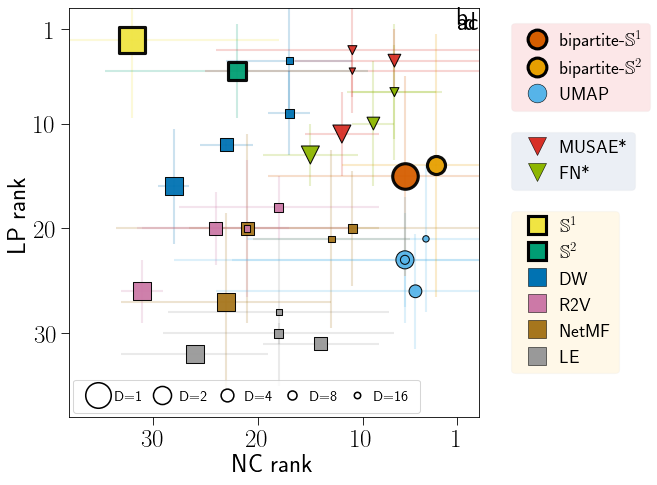

In [42]:
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

col_network_based = '#FFC325'#'#f6c200'
col_feature_based = '#E31B23'#'#a00e00'
col_feature_network_based = '#4063a3'#'#0086a8'

methods_category = {'UMAP': col_feature_based, 
                    'DW': col_network_based, 
                    'R2V': col_network_based, 
                    'LE': col_network_based, 
                    'NetMF': col_network_based, 
                    'FN*': col_feature_network_based, 
                    'MUSAE*': col_feature_network_based,
                    '$\mathbb{S}^1$': col_network_based,
                    'bipartite-$\mathbb{S}^1$': col_feature_based,
                    '$\mathbb{S}^2$': col_network_based,
                    'bipartite-$\mathbb{S}^2$': col_feature_based}

method_colors = {
    'bipartite-$\\mathbb{S}^1$': '#D55E00',  # Vermilion
    'bipartite-$\\mathbb{S}^2$': '#E69F00',  # Orange
    '$\\mathbb{S}^1$': '#F0E442',            # Yellow
    '$\\mathbb{S}^2$': '#009E73',            # Bluish Green
    'UMAP': '#56B4E9',                       # Sky Blue
    'DW': '#0072B2',                         # Blue
    'R2V': '#CC79A7',                        # Reddish Purple
    'LE': '#999999',                         # Gray
    'NetMF': '#A6761D',                      # Brown
    'FN*': '#8DB600',                        # Bluish Green (reused for balance)
    'MUSAE*': '#D73027'                      # Strong Red
}

method_markers = {
    'bipartite-$\\mathbb{S}^1$': 'o',  
    'bipartite-$\\mathbb{S}^2$': 'o',  
    '$\\mathbb{S}^1$': 's',            
    '$\\mathbb{S}^2$': 's',            
    'UMAP': 'o',                       
    'DW': 's',                         
    'R2V': 's',                       
    'LE': 's',                         
    'NetMF': 's',                      
    'FN*': 'v',                        
    'MUSAE*': 'v'                      
}

fig, axs = plt.subplots(1, figsize=(7,7))

labels_1 = ['bipartite-$\mathbb{S}^1$', 'bipartite-$\mathbb{S}^2$', 'UMAP']
get_edge_width = lambda x: 3 if 'mathbb' in x else 0.5 
legend_elements_1 = [
    Line2D([0], [0], marker=method_markers[method],
           color='w', markerfacecolor=method_colors[method],linestyle='none',
           markersize=18, mec='black', mew=get_edge_width(method), label=method)
    for method in labels_1
]

labels_2 = ['MUSAE*', 'FN*']
legend_elements_2 = [
    Line2D([0], [0], marker=method_markers[method],linestyle='none',
           color='w', markerfacecolor=method_colors[method],
           markersize=18, mec='black', mew=0.5, label=method)
    for method in labels_2
]

labels_3 = ['$\\mathbb{S}^1$', '$\\mathbb{S}^2$', 'DW', 'R2V', 'NetMF', 'LE']
legend_elements_3 = [
    Line2D([0], [0], marker=method_markers[method],linestyle='none',
           color='w', markerfacecolor=method_colors[method],
           markersize=18, mec='black', mew=get_edge_width(method), label=method)
    for method in labels_3
]

fig.legend(legend_elements_1, labels_1,bbox_to_anchor=(1.01, 0.75),
          fontsize=18, loc=(0,0), ncol=1, columnspacing=0.3, handletextpad=0.2,
            facecolor=col_feature_based, framealpha=0.1)
fig.legend(legend_elements_2,  labels_2, bbox_to_anchor=(1.01, 0.6),
          fontsize=18, loc=(0,0), ncol=1, columnspacing=0.3, handletextpad=0.2,
          facecolor=col_feature_network_based, framealpha=0.1)
fig.legend(legend_elements_3, labels_3, bbox_to_anchor=(1.01, 0.25),
          fontsize=18, loc=(0,0), ncol=1, columnspacing=0.3, handletextpad=0.2,
          facecolor=col_network_based, framealpha=0.1)

for method in grouped_with_std['method'].unique():
    subset = grouped_with_std[grouped_with_std['method'] == method]
    if 'mathbb' in method:
        linewidths = 3
    else:
        linewidths = 1
        
    axs.scatter(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        s=subset["point_size"] * 600,
        alpha=0.95,
        edgecolor='black',
        color=method_colors[method],
        linewidths=linewidths,
        zorder=20,
        marker=method_markers[method]
    )
    axs.errorbar(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        xerr=subset["std_rank_x"],
        yerr=subset["std_rank_y"],
        fmt='none',
        ecolor=method_colors[method],
        alpha=0.2,
        capsize=0,
        zorder=0,
        elinewidth=2,
    )

axs.set_xlabel("NC rank")
axs.set_ylabel("LP rank")
axs.set_yticks([1, 10, 20, 30])
axs.set_xticks([1, 10, 20, 30])
axs.set_xlim(-1, 38)
axs.set_ylim(-1, 38)

axs.xaxis.set_inverted(True)
axs.yaxis.set_inverted(True)

dim_legend_sizes = sorted(grouped_with_std['dim'].unique())
legend_elements_sizes = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
           markersize=np.sqrt((1 / dim) * 600), mec='black', mew=1.5, 
           label=f"D={dim}")
    for dim in dim_legend_sizes
]

axs.legend(handles=legend_elements_sizes, loc=(0.01, 0.01), fontsize=14, labelspacing=0.8,
             borderpad=0.7, ncol=5, columnspacing=0.3, handletextpad=0.2)


# just for inkscape
axs.text(1,1,'a')
axs.text(1,0.5,'b')
axs.text(0,1,'c')
axs.text(0.4,1,'d')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/average_lp_nc_rank_rotate_inverse_framed.pdf",
#            bbox_inches='tight')

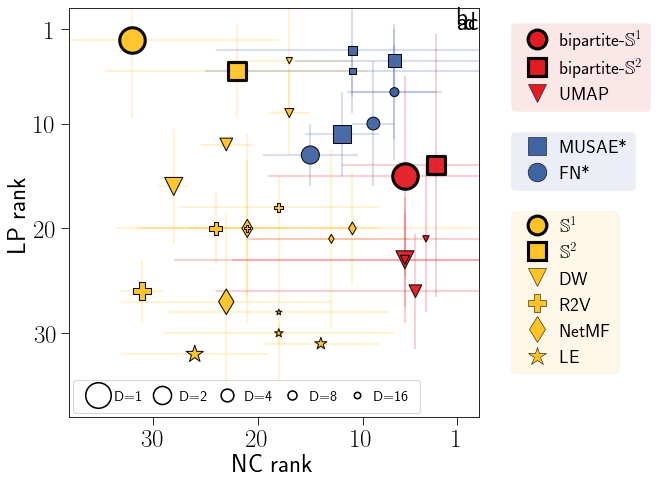

In [48]:
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

col_network_based = '#FFC325'#'#f6c200'
col_feature_based = '#E31B23'#'#a00e00'
col_feature_network_based = '#4063a3'#'#0086a8'

methods_category = {'UMAP': col_feature_based, 
                    'DW': col_network_based, 
                    'R2V': col_network_based, 
                    'LE': col_network_based, 
                    'NetMF': col_network_based, 
                    'FN*': col_feature_network_based, 
                    'MUSAE*': col_feature_network_based,
                    '$\mathbb{S}^1$': col_network_based,
                    'bipartite-$\mathbb{S}^1$': col_feature_based,
                    '$\mathbb{S}^2$': col_network_based,
                    'bipartite-$\mathbb{S}^2$': col_feature_based}


method_colors = {
    'bipartite-$\\mathbb{S}^1$': col_feature_based,
    'bipartite-$\\mathbb{S}^2$': col_feature_based,
    '$\\mathbb{S}^1$': col_network_based,           
    '$\\mathbb{S}^2$': col_network_based,       
    'UMAP': col_feature_based,  
    'DW': col_network_based,                       
    'R2V': col_network_based,                       
    'LE': col_network_based,                         
    'NetMF': col_network_based,                      
    'FN*': col_feature_network_based,    
    'MUSAE*': col_feature_network_based       
}


method_markers = {
    'bipartite-$\\mathbb{S}^1$': 'o',  
    'bipartite-$\\mathbb{S}^2$': 's',  
    '$\\mathbb{S}^1$': 'o',            
    '$\\mathbb{S}^2$': 's',            
    'UMAP': 'v',                       
    'DW': 'v',                         
    'R2V': 'P',                       
    'LE': '*',                         
    'NetMF': 'd',                      
    'FN*': 'o',                        
    'MUSAE*': 's'                      
}

fig, axs = plt.subplots(1, figsize=(7,7))

labels_1 = ['bipartite-$\mathbb{S}^1$', 'bipartite-$\mathbb{S}^2$', 'UMAP']
get_edge_width = lambda x: 3 if 'mathbb' in x else 0.5 
legend_elements_1 = [
    Line2D([0], [0], marker=method_markers[method],
           color='w', markerfacecolor=method_colors[method],linestyle='none',
           markersize=18, mec='black', mew=get_edge_width(method), label=method)
    for method in labels_1
]

labels_2 = ['MUSAE*', 'FN*']
legend_elements_2 = [
    Line2D([0], [0], marker=method_markers[method],linestyle='none',
           color='w', markerfacecolor=method_colors[method],
           markersize=18, mec='black', mew=0.5, label=method)
    for method in labels_2
]

labels_3 = ['$\\mathbb{S}^1$', '$\\mathbb{S}^2$', 'DW', 'R2V', 'NetMF', 'LE']
legend_elements_3 = [
    Line2D([0], [0], marker=method_markers[method],linestyle='none',
           color='w', markerfacecolor=method_colors[method],
           markersize=18, mec='black', mew=get_edge_width(method), label=method)
    for method in labels_3
]

fig.legend(legend_elements_1, labels_1,bbox_to_anchor=(1.01, 0.75),
          fontsize=18, loc=(0,0), ncol=1, columnspacing=0.3, handletextpad=0.2,
            facecolor=col_feature_based, framealpha=0.1)
fig.legend(legend_elements_2,  labels_2, bbox_to_anchor=(1.01, 0.6),
          fontsize=18, loc=(0,0), ncol=1, columnspacing=0.3, handletextpad=0.2,
          facecolor=col_feature_network_based, framealpha=0.1)
fig.legend(legend_elements_3, labels_3, bbox_to_anchor=(1.01, 0.25),
          fontsize=18, loc=(0,0), ncol=1, columnspacing=0.3, handletextpad=0.2,
          facecolor=col_network_based, framealpha=0.1)

for method in grouped_with_std['method'].unique():
    subset = grouped_with_std[grouped_with_std['method'] == method]
    if 'mathbb' in method:
        linewidths = 3
    else:
        linewidths = 1
        
    axs.scatter(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        s=subset["point_size"] * 600,
        alpha=0.95,
        edgecolor='black',
        color=method_colors[method],
        linewidths=linewidths,
        zorder=20,
        marker=method_markers[method]
    )
    axs.errorbar(
        subset["avg_rank_x"],
        subset["avg_rank_y"],
        xerr=subset["std_rank_x"],
        yerr=subset["std_rank_y"],
        fmt='none',
        ecolor=method_colors[method],
        alpha=0.2,
        capsize=0,
        zorder=0,
        elinewidth=2,
    )

axs.set_xlabel("NC rank")
axs.set_ylabel("LP rank")
axs.set_yticks([1, 10, 20, 30])
axs.set_xticks([1, 10, 20, 30])
axs.set_xlim(-1, 38)
axs.set_ylim(-1, 38)

axs.xaxis.set_inverted(True)
axs.yaxis.set_inverted(True)

dim_legend_sizes = sorted(grouped_with_std['dim'].unique())
legend_elements_sizes = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='none', 
           markersize=np.sqrt((1 / dim) * 600), mec='black', mew=1.5, 
           label=f"D={dim}")
    for dim in dim_legend_sizes
]

axs.legend(handles=legend_elements_sizes, loc=(0.01, 0.01), fontsize=14, labelspacing=0.8,
             borderpad=0.7, ncol=5, columnspacing=0.3, handletextpad=0.2)


# just for inkscape
axs.text(1,1,'a')
axs.text(1,0.5,'b')
axs.text(0,1,'c')
axs.text(0.4,1,'d')

plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/plots/average_lp_nc_rank_rotate_inverse_framed_by_markers.pdf",
#            bbox_inches='tight')

---
---
AUC
---
---

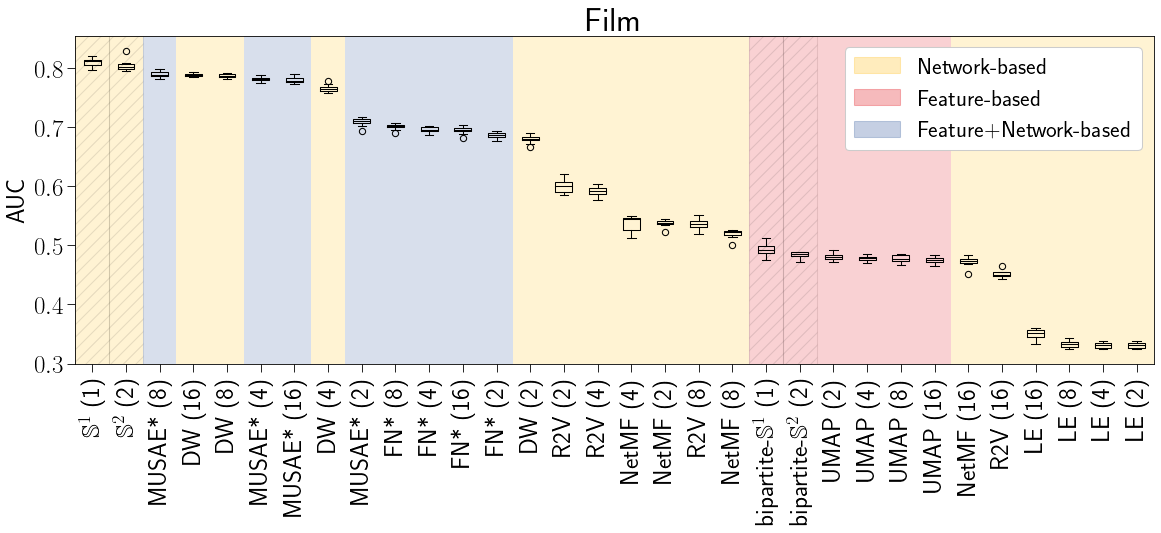

In [270]:
lp_res_film = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/film_auc_10.csv")
mean_values = lp_res_film.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_film['method_dim'] = pd.Categorical(lp_res_film['method_dim'],
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_film, 'Film', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_film.pdf")

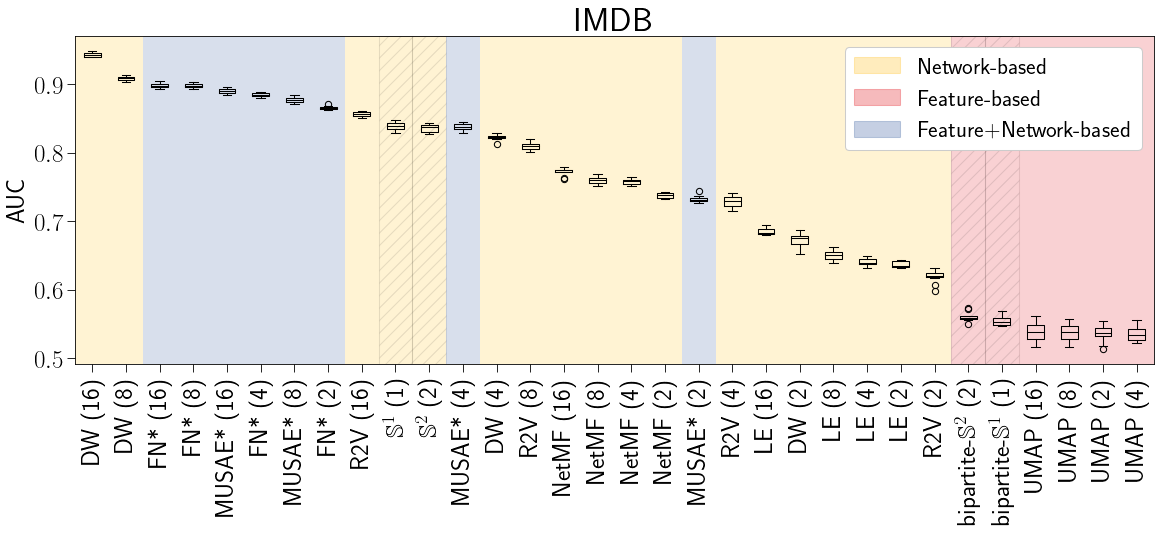

In [271]:
lp_res_imdb = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/imdb_mam_auc_10.csv")
mean_values = lp_res_imdb.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_imdb['method_dim'] = pd.Categorical(lp_res_imdb['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_imdb, 'IMDB', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_imdb.pdf")

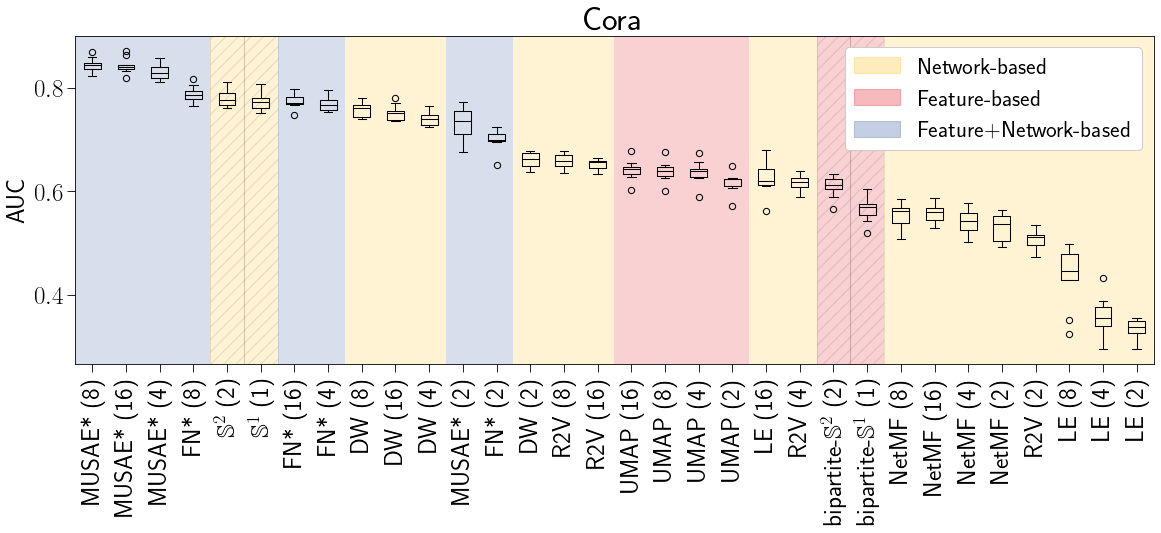

In [279]:
lp_res_cora = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Cora_auc_10.csv")
mean_values = lp_res_cora.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_cora['method_dim'] = pd.Categorical(lp_res_cora['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_cora, 'Cora', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_cora.pdf")

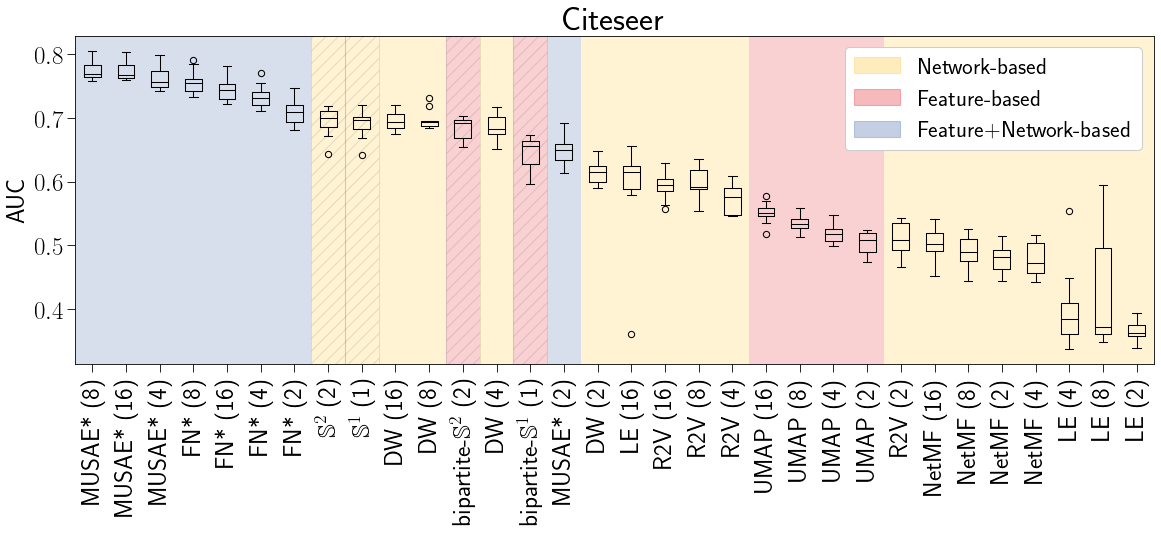

In [273]:
lp_res_citeseer = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Citeseer_auc_10.csv")
mean_values = lp_res_citeseer.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_citeseer['method_dim'] = pd.Categorical(lp_res_citeseer['method_dim'], 
                                           categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_citeseer, 'Citeseer', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_citeseer.pdf")


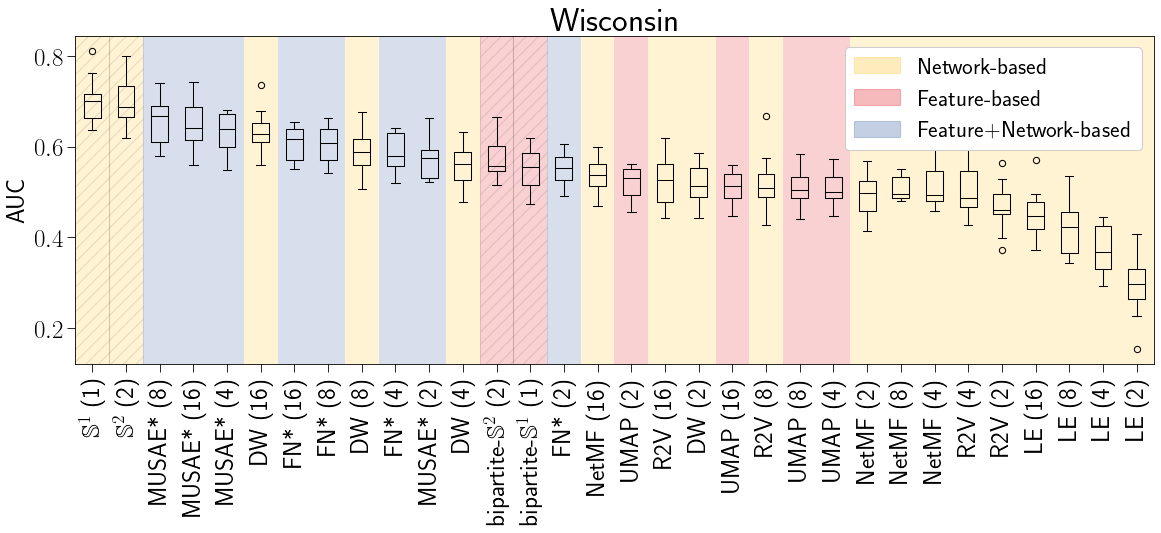

In [274]:
lp_res_wisconsin = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Wisconsin_auc_10.csv")
mean_values = lp_res_wisconsin.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_wisconsin['method_dim'] = pd.Categorical(lp_res_wisconsin['method_dim'], 
                                                categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_wisconsin, 'Wisconsin', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_wisconsin.pdf")

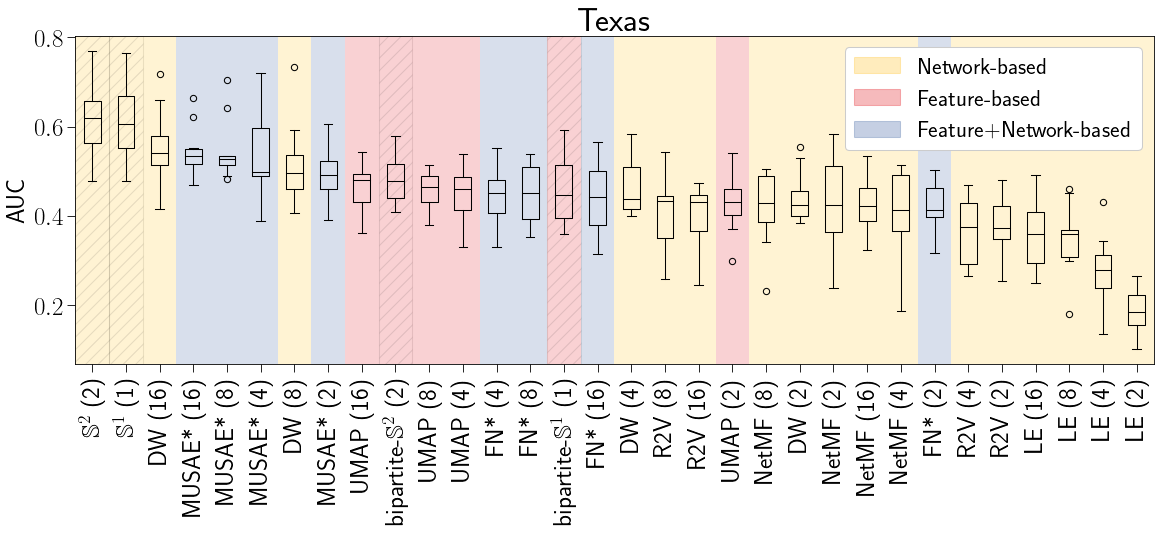

In [275]:
lp_res_texas = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Texas_auc_10.csv")
mean_values = lp_res_texas.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_texas['method_dim'] = pd.Categorical(lp_res_texas['method_dim'], 
                                            categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_texas, 'Texas', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_texas.pdf")

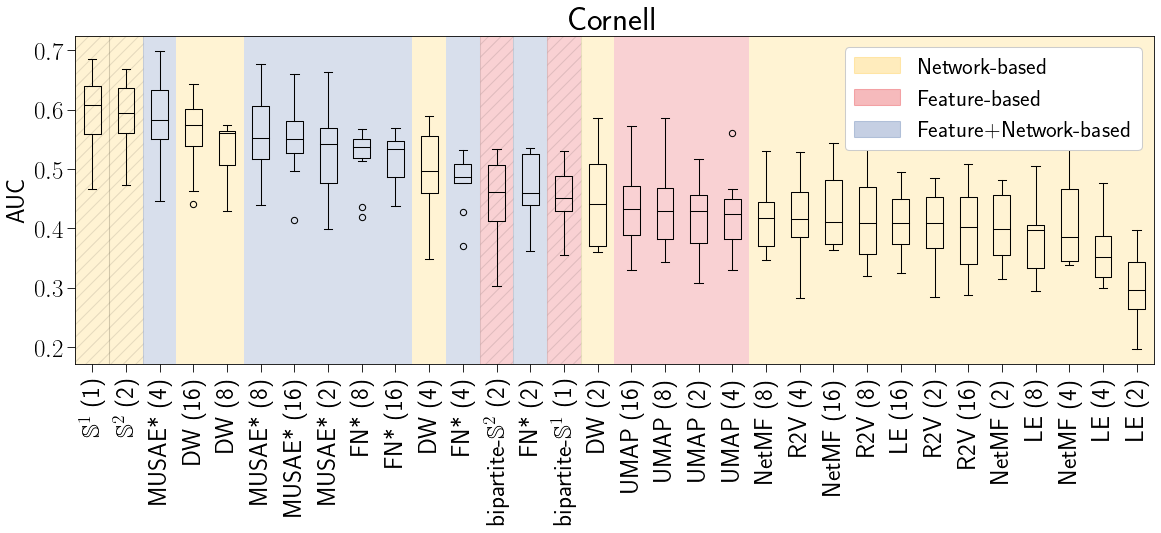

In [276]:
lp_res_cornell = pd.read_csv("/home/rob/Dropbox/Run-GNNs-on-Real-datasets-20-09-2024/LP-Results/csv-files/Cornell_auc_10.csv")
mean_values = lp_res_cornell.groupby('method_dim')['value'].median().sort_values(ascending=False)
lp_res_cornell['method_dim'] = pd.Categorical(lp_res_cornell['method_dim'], 
                                            categories=mean_values.index, ordered=True)
plot_boxplot(lp_res_cornell, 'Cornell', 'AUC')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_cornell.pdf")

In [277]:
lp_rank_film = get_ranking(lp_res_film)
lp_rank_imdb = get_ranking(lp_res_imdb)
lp_rank_cora = get_ranking(lp_res_cora)
lp_rank_citeseer = get_ranking(lp_res_citeseer)
lp_rank_wisconsin = get_ranking(lp_res_wisconsin)
lp_rank_texas = get_ranking(lp_res_texas)
lp_rank_cornell = get_ranking(lp_res_cornell)

/tmp/ipykernel_157973/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_157973/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_157973/1836551368.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_ranking = res.groupby(['method_dim'])\
/tmp/ipykernel_157973/1836551368.py:3: Futu

In [ ]:
plot_rank_boxplot([lp_rank_film, lp_rank_imdb, lp_rank_cora, lp_rank_citeseer,
                   lp_rank_wisconsin, lp_rank_texas, lp_rank_cornell], 'Link Prediction')

# plt.savefig("/home/rob/Dropbox/Robert/FeatureMercator/Paper/SI/plots/lp_auc_rank.pdf")

[autoreload of numpy.core failed: Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 439, in superreload
    if not append_obj(module, old_objects, name, obj):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 407, in append_obj
    in_module = hasattr(obj, "__module__") and obj.__module__ == module.__name__
  File "/home/rob/.local/lib/python3.10/site-packages/numpy/core/defchararray.py", line 2, in __getattr__
    from numpy._core import defchararray
  File "/home/rob/.local/lib/python3.10/site-packages/numpy/_core/defchararray.py", line 25, in <module>
    from numpy.strings import *
  File "/home/rob/.local/lib/python3.10/site-packages/numpy/strings/__init__.py", line 1, in <module>
    from numpy._core.strings import __all__, __doc__
  File "/hom


Bad key axes3d.mouserotationstyle in file /home/rob/.local/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc, line 442 ('axes3d.mouserotationstyle: arcball  # {azel, trackball, sphere, arcball}')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key axes3d.trackballsize in file /home/rob/.local/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc, line 444 ('axes3d.trackballsize: 0.667  # trackball diameter, in units of the Axes bbox')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.0/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution

Bad key axes3d.trackballborder in file /home/rob/.local/lib/python3.10/site-packages/matplotlib/mpl-data/matplotlibrc, line 445 ("axes3d.trackballborder: 0.2  # trackball border width, in units of

[autoreload of matplotlib.dviread failed: Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 349, in update_class
    update_instances(old, new)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 307, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'Text' object layout differs from 'Text'
]
[autoreload of matplotlib._mathtext failed: Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", li

[autoreload of matplotlib.offsetbox failed: Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 484, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 333, in update_class
    if update_generic(old_obj, new_obj):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 381, in update_generic
    update(a, b)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 293, in update_function
    setattr(old, name, getattr(new, name))
ValueError: __init__() requires a code object with 4 free vars, not 1
]
[autoreload of matplotlib.axis f

[autoreload of matplotlib.tri._triinterpolate failed: Traceback (most recent call last):
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/usr/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/home/rob/.local/lib/python3.10/site-packages/matplotlib/tri/_triinterpolate.py", line 578, in <module>
    class _ReducedHCT_Element:
  File "/home/rob/.local/lib/python3.10/site-packages/matplotlib/tri/_triinterpolate.py", line 665, in _ReducedHCT_Element
    gauss_w = np.ones([9], dtype=np.float64) / 9.
  Fil